# Statistical study
Here we study in the SI model the performances of Causality compared to the other methods. We make a statistical study, i.e. we make inference for several instances in order to find the average AUROC currves with errorbars

In [ ]:
using SparseArrays, LinearAlgebra
using Causality
using PyCall
using IntervalUnionArithmetic
using ProgressMeter
using DelimitedFiles

T = 20.0
N = 200

@pyimport sib
function NonMarkovDynamicSibyl(N, T_cont, Λ, V, a, b, c, O, γ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    i = findnz(G.A)[1]
    j = findnz(G.A)[2]    
    contacts = [(i[a]-1, j[a]-1, t, 1.) for t in 1:T for a = 1:nnz(Λ.A) if (t * dt) in V[Λ.A.rowval[a]].mask];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    g = sib.PiecewiseLinear(pycall(sib.RealParams, PyObject, [a*exp(-((t-b)/c)^2) * dt for t =1:T]))
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=1e-10,fp_rate=1e-10,fn_rate=1e-10, prob_i = g)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end

function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end
ε = 1e-10
λ = 0.6
pseed = 1/N
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI
#Initialize min/max boundaies


#Initialize generation parameters
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
inf_out = GaussianRate(λ, 3., 2.)

dt = 1/4
xtrue = zeros(N)
ρ = 2.1 / N
G = Causality.makeProximity(N,ρ)
V = map(Causality.edges(G)) do _
    r = T*rand()
    s = min(r + rand()*6, T)
    mask = Interval(r,s)
    n_contacts = rand(1:5)
    for cont ∈ 1:n_contacts
        r = T*rand()
        s = min(r + rand()*6, T) 
        mask = mask ∪ Interval(r,s)
    end
    MaskedRate(UnitRate(), mask)
end;
O=[]
for samples = 1:35
    N = rand(200:800)
    getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

    getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]

    pseed_min = ε
    pseed_max = 1-ε
    rate_min = GaussianRate(ε  ,  -T,   ε)
    rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

    θmin = getpar(pseed_min , rate_min, rate_min);
    θmax = getpar(pseed_max , rate_max, rate_max);

    rate_min = GaussianRate(ε  ,  -T,   ε)
    rate_max = GaussianRate(1/ε  ,  T,   T)

    θgenmin = getpargen(pseed_min, rate_min, rate_min);
    θgenmax = getpargen(pseed_max, rate_max, rate_max);
    
    θp = getpar(pseed, autoinf, inf_in);
    θpgen = getpargen(pseed, autoinf, inf_out);
    xtrue = zeros(N)
    ρ = 2 / N
    pseed = 1/N
    G = Causality.makeProximity(N,ρ)
    V = map(Causality.edges(G)) do _
        r = T*rand()
        s = min(r + rand()*6, T)
        mask = Interval(r,s)
        n_contacts = rand(1:5)
        for cont ∈ 1:n_contacts
            r = T*rand()
            s = min(r + rand()*6, T) 
            mask = mask ∪ Interval(r,s)
        end
        MaskedRate(UnitRate(), mask)
    end;

    Mp = StochasticModel(Igen, T, θp, G, θpgen,V);
    sample! = Sampler(Mp);
    nobs, p = Int(round(N/30)), 1e-5
    ni = 0
    ninf = 0
    O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
    while !(0 < ni < nobs) && !(N/3 < ninf < N/1.7)
        sample!(xtrue)
        O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
        ni = length([o for o in O if o[2] == 1])
        ninf = sum(xtrue .< T)
    end
    #Softened model
    ε = 2e-3
    autoinf = GaussianRate(ε, T/2, T/2);
    θp2gen = getpargen(pseed, autoinf, inf_out);
    inf_in = GaussianRate(1., T/2, 3*T );

    θp2 = getpar(pseed, autoinf, inf_in);
    Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen, V);
    #Causality
    θ = getpar(pseed, autoinf, inf_in);
    M = StochasticModel(Igauss, T, θ, G, θp2gen, V);
    ProgressMeter.ijulia_behavior(:clear)
    descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
             hyperdescender=SignDescender(0.));
    descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
             θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
             hyperdescender=SignDescender(0.));
    statscau = prior(M, numsamples=10^4);
    stats = softpost(Mp, O; numsamples=10^5);

    p_sib = NonMarkovDynamicSibyl(N, T, G, V, inf_out.a, inf_out.b, inf_out.c, O, 1/N; dt=dt, maxit = 40, tol = 1e-7);

    #Heuristic
    struct HeuristicSI <: SI end
    maskauto = fill(IntervalUnion(0., T),N)
    maskinf = fill(IntervalUnion(0., T),N)
    θfrench = getpar(pseed, GaussianRate(1e-10,T,T), inf_in);
    Causality.individual(M::StochasticModel{HeuristicSI}, i::Int, θi = @view(M.θ[:,i]), θg = M.θgen ) = 
    @views IndividualSI(θi[1], 
        MaskedRate(GaussianRate(θi[2:4]...),maskauto[i]), 
        MaskedRate(UnitRate(),maskinf[i]), 
        GaussianRate(θg[5:7]...),)
    for o in O
        if o[2] == 1 
            maskauto[o[1]] = maskauto[o[1]] ∩ IntervalUnion(o[3]-5, T)        
            θfrench[2,o[1]] = 10
            θfrench[3,o[1]] = o[3] - 5
            θfrench[4,o[1]] = 10
        elseif o[2] == 0
            maskinf[o[1]] = maskinf[o[1]] ∩ IntervalUnion(o[3], T)
            θfrench[1,o[1]] = 1e-10
        end
    end
    Mfrench = StochasticModel(HeuristicSI, T, θfrench, G, θp2gen);
    statsfre = prior(Mfrench,numsamples=10^5);
    #Metropolis MC
    xstart = zeros(N)
    sample!(xstart)
    K = Causality.GaussMove(2.)
    stats_mh = Causality.metropolis_sampling_sequential(Mp, O, K; numsamples = 2000,numsteps=10^3, x = xstart);
    #AUROC
    Td = Int(T)
    AU_curve=zeros(Td)
    AU_sib=zeros(Td)
    AU_french = zeros(Td)
    AU_soft = zeros(Td)
    AU_MH = zeros(Td)
    for t = 1:Td
        cau_risk=zeros(N)
        sib_risk = zeros(N)
        french_risk = zeros(N)
        MH_risk = zeros(N)
        soft_risk = zeros(N)
        for i=1:N
           cau_risk[i] = marginal(i,t,statscau)
           french_risk[i] = marginal(i,t,statsfre)
           MH_risk[i] = marginal(i,t,stats_mh)
           sib_risk[i] = p_sib[i,Int(round(t/dt))]
           soft_risk[i] = marginal(i,t,stats) 
        end
        xt = xtrue .< t
        AU_soft[t] = AUROC(ROC(xt, soft_risk))
        AU_curve[t] = AUROC(ROC(xt, cau_risk))
        AU_french[t] = AUROC(ROC(xt, french_risk))
        AU_MH[t] = AUROC(ROC(xt, MH_risk))
        AU_sib[t] = AUROC(ROC(xt, sib_risk))
    end
    open("./SIstudy/cau.txt","a") do io
       writedlm(io,AU_curve') 
    end
    open("./SIstudy/sib.txt","a") do io
        writedlm(io,AU_sib')  
    end
    open("./SIstudy/fre.txt","a") do io
        writedlm(io,AU_french') 
    end
    open("./SIstudy/mc.txt","a") do io
        writedlm(io,AU_MH') 
    end
    open("./SIstudy/soft.txt","a") do io
        writedlm(io,AU_soft') 
    end

end

In [9]:
rand(200:800)

372

In [1]:
using DelimitedFiles
iniz = 1
cau=readdlm("./SIstudy/cau.txt")[iniz:end,:]
sib_r=readdlm("./SIstudy/sib.txt")[iniz:end,:]
fre=readdlm("./SIstudy/fre.txt")[iniz:end,:]
mc=readdlm("./SIstudy/mc.txt")[iniz:end,:]
soft=readdlm("./SIstudy/soft.txt")[iniz:end,:]

44×20 Matrix{Float64}:
   0.716981     0.730189    0.770913  …  0.96229   0.980049  0.982732
   0.63371      0.52741     0.612121     0.748747  0.745136  0.717418
   0.953226     0.953226    0.953226     0.556753  0.555931  0.546825
   0.0231214    0.398649    0.413981     0.667624  0.641136  0.619733
 NaN          NaN         NaN            0.511628  0.532738  0.513243
   0.658871     0.652419    0.645227  …  0.682172  0.674699  0.68697
   0.442241     0.404052    0.376968     0.76095   0.749593  0.754208
   0.697521     0.571606    0.492802     0.50732   0.506706  0.516643
 NaN          NaN         NaN            0.750305  0.750361  0.74373
   0.605469     0.537912    0.514613     0.516978  0.510371  0.521287
   0.230047     0.421978    0.565129  …  0.815456  0.807111  0.807448
 NaN            0.197959    0.404938     0.871049  0.868526  0.864292
 NaN            0.313394    0.243807     0.727901  0.72691   0.735417
   ⋮                                  ⋱                      
   0.89

In [2]:
for s = 1:size(cau,1)
    for t = 1:size(cau,2)
        isnan(cau[s,t]) && (cau[s,t] = 1)
    end
end
for s = 1:size(sib_r,1)
    for t = 1:size(sib_r,2)
        isnan(sib_r[s,t]) && (sib_r[s,t] = 1)
    end
end
for s = 1:size(fre,1)
    for t = 1:size(fre,2)
        isnan(fre[s,t]) && (fre[s,t] = 1)
    end
end
for s = 1:size(mc,1)
    for t = 1:size(mc,2)
        isnan(mc[s,t]) && (mc[s,t] = 1)
    end
end
for s = 1:size(soft,1)
    for t = 1:size(soft,2)
        isnan(soft[s,t]) && (soft[s,t] = 1)
    end
end

In [3]:
cau_avg = sum(cau,dims=1)/size(cau,1)
sib_r_avg = sum(sib_r,dims=1)/size(sib_r,1)
fre_avg = sum(fre,dims=1)/size(fre,1)
mc_avg = sum(mc,dims=1)/size(mc,1)
soft_avg = sum(soft,dims=1)/size(soft,1)

1×20 Matrix{Float64}:
 0.673847  0.604209  0.638306  0.648345  …  0.742687  0.74225  0.740435

In [4]:
cau_err = sqrt.(sum((cau .- cau_avg) .^ 2,dims=1)/size(cau,1))/sqrt(size(cau,1))
sib_r_err = sqrt.(sum((sib_r .- sib_r_avg) .^ 2,dims=1)/size(sib_r,1))/sqrt(size(sib_r,1))
fre_err = sqrt.(sum(( fre.- fre_avg) .^ 2,dims=1)/size(fre,1))/sqrt(size(fre,1))
mc_err = sqrt.(sum((mc .- mc_avg) .^ 2,dims=1)/size(mc,1))/sqrt(size(mc,1))
soft_err = sqrt.(sum((soft .- soft_avg) .^ 2,dims=1)/size(soft,1))/sqrt(size(soft,1))

1×20 Matrix{Float64}:
 0.0415987  0.0381266  0.0327875  0.029183  …  0.019617  0.0196827  0.0199047

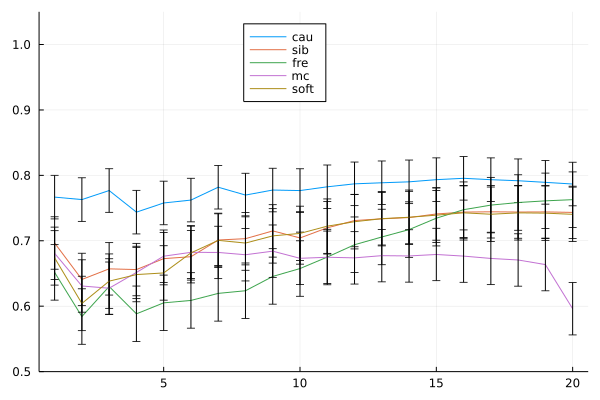

In [6]:
using Plots
plot(cau_avg',yerr=cau_err,label="cau",legend=:top)
plot!(sib_r_avg',yerr=sib_r_err,label="sib")
plot!(fre_avg',yerr=fre_err,label="fre")
plot!(mc_avg',yerr=mc_err,label="mc")
plot!(soft_avg',yerr=soft_err,label="soft")
ylims!(0.5,1.05)

In [19]:
[o for o in O if o[2]==1]

4-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (2, 1, 13.683055357209003, 1.0e-5)
 (9, 1, 17.17002311193889, 1.0e-5)
 (10, 1, 17.990827145314434, 1.0e-5)
 (12, 1, 11.633293446216966, 1.0e-5)

In [20]:
O

19-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 12.141205162015494, 1.0e-5)
 (2, 1, 13.683055357209003, 1.0e-5)
 (3, 0, 19.577951923205696, 1.0e-5)
 (4, 0, 10.114722257136297, 1.0e-5)
 (5, 0, 19.789447722677558, 1.0e-5)
 (6, 0, 19.05819358370653, 1.0e-5)
 (7, 0, 10.742865808941344, 1.0e-5)
 (8, 0, 10.525772901170003, 1.0e-5)
 (9, 1, 17.17002311193889, 1.0e-5)
 (10, 1, 17.990827145314434, 1.0e-5)
 (11, 0, 19.4175293497739, 1.0e-5)
 (12, 1, 11.633293446216966, 1.0e-5)
 (13, 0, 10.877873134848652, 1.0e-5)
 (14, 0, 14.2220087976373, 1.0e-5)
 (15, 0, 10.125015587413957, 1.0e-5)
 (16, 0, 10.89783234373245, 1.0e-5)
 (17, 0, 11.691437511815487, 1.0e-5)
 (18, 0, 10.223919188107011, 1.0e-5)
 (19, 0, 16.568987068091875, 1.0e-5)

In [21]:
V

3306-element Vector{MaskedRate{UnitRate}}:
 MaskedRate{UnitRate}(UnitRate(), [2.5003, 8.16911] ∪ [15.3139, 15.4193])
 MaskedRate{UnitRate}(UnitRate(), [6.34491, 16.0039] ∪ [17.1776, 19.5729])
 MaskedRate{UnitRate}(UnitRate(), [6.39844, 9.69771] ∪ [16.489, 17.4341])
 MaskedRate{UnitRate}(UnitRate(), [4.74636, 13.0059]ᵤ)
 MaskedRate{UnitRate}(UnitRate(), [13.6047, 15.5117] ∪ [17.281, 20])
 MaskedRate{UnitRate}(UnitRate(), [3.03729, 8.65462] ∪ [10.1425, 12.4414])
 MaskedRate{UnitRate}(UnitRate(), [3.08359, 4.2191] ∪ [4.82149, 9.8865] ∪ [12.6226, 15.9153] ∪ [19.6806, 20])
 MaskedRate{UnitRate}(UnitRate(), [5.5418, 6.69064] ∪ [7.72805, 12.2355] ∪ [13.162, 19.5778])
 MaskedRate{UnitRate}(UnitRate(), [4.5489, 7.34541] ∪ [19.6244, 20])
 MaskedRate{UnitRate}(UnitRate(), [7.13645, 7.4876] ∪ [12.3271, 17.8595])
 MaskedRate{UnitRate}(UnitRate(), [1.13274, 4.70209] ∪ [5.44938, 7.73151] ∪ [7.95914, 8.46868] ∪ [9.07189, 12.0157] ∪ [17.8295, 20])
 MaskedRate{UnitRate}(UnitRate(), [6.17482, 6.85769] ∪ 